In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt


In [3]:


# Descargar datos 
def get_data(stocks, start, end):
    prices = yf.download(stocks, start, end, progress=False)['Close']
    returns = prices.pct_change()
    mean_returns = returns.mean()
    matriz_cov = returns.cov()
    return mean_returns, matriz_cov

# Simulación de portafolio
def simular_precios(num_simulaciones, weights, mean_returns, matriz_cov, num_dias):
    port_returns = np.full((num_simulaciones, num_dias), 0.0)

    for i in range(num_simulaciones):
        L = np.linalg.cholesky(matriz_cov)
        z = np.random.normal(0, 1, (num_dias, len(weights)))
        daily_returns = mean_returns.values + z @ L.T
        daily_portfolio_returns = daily_returns @ weights
        cumulative_returns = np.cumprod(daily_portfolio_returns + 1)
        port_returns[i, :] = cumulative_returns

    return port_returns


# Cálculo de métricas de riesgo
def calcular_metricas(rendimientos_finales, nivel_1=0.95, nivel_2=0.99):
    # Rendimiento acumulado al final del periodo
    rendimientos = rendimientos_finales - 1

    prob_perdida = np.mean(rendimientos < 0)
    var_95 = np.percentile(rendimientos, 100 * (1 - nivel_1))
    var_99 = np.percentile(rendimientos, 100 * (1 - nivel_2))
    cvar_95 = rendimientos[rendimientos <= var_95].mean()

    return {
        "Probabilidad de pérdida": prob_perdida,
        "VaR 95%": var_95,
        "VaR 99%": var_99,
        "CVaR 95%": cvar_95
    }


# Visualización de resultados
def graficar_histograma(rendimientos, var_95, var_99):
    plt.figure(figsize=(10,6))
    plt.hist(rendimientos, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(var_95, color='red', linestyle='--', label=f'VaR 95%: {var_95:.2%}')
    plt.axvline(var_99, color='purple', linestyle='--', label=f'VaR 99%: {var_99:.2%}')
    plt.title('Histograma de rendimientos simulados')
    plt.xlabel('Rendimiento')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    plt.show()


# Mostrar tabla de métricas
def mostrar_metricas(metricas):
    df = pd.DataFrame(metricas, index=['Valor']).T
    df.columns = ['Resultado']
    df['Resultado'] = df['Resultado'].apply(lambda x: f"{x:.2%}")
    print(df)

C:\Users\alvaro.morales\AppData\Local\Temp\ipykernel_5968\2041319386.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(stocks, start, end, progress=False)['Close']


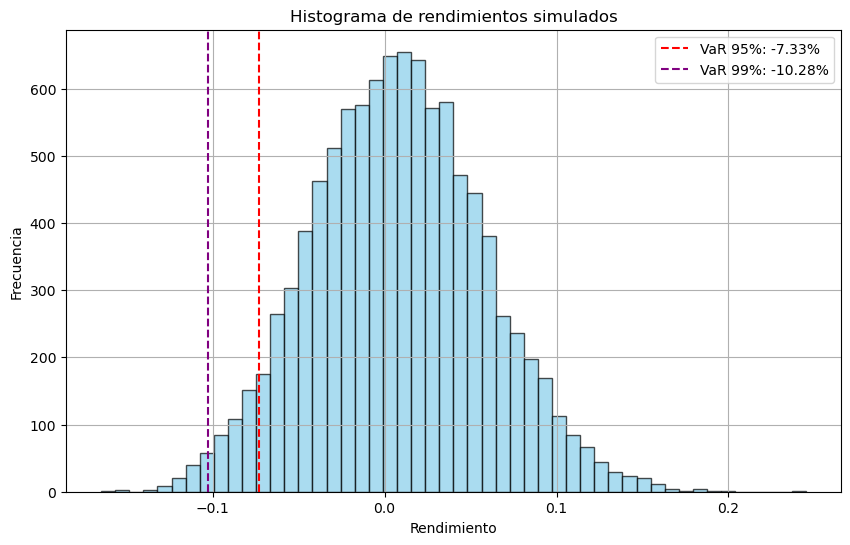

                        Resultado
Probabilidad de pérdida    44.08%
VaR 95%                    -7.33%
VaR 99%                   -10.28%
CVaR 95%                   -9.15%


In [6]:
# Ejecutar todo el proceso
def ejecutar_simulacion():
    stocks = ["AAPL", "KO", "F"]
    weights = np.array([0.5, 0.2, 0.3])
    num_dias = 14
    num_simulaciones = 10000
    start_date = dt.datetime.now() - dt.timedelta(days=365 * 4)
    end_date = dt.datetime.now()

    mean_returns, matriz_cov = get_data(stocks, start_date, end_date)
    rendimientos_portafolio = simular_precios(num_simulaciones, weights, mean_returns, matriz_cov, num_dias)
    
    rendimientos_finales = rendimientos_portafolio[:, -1]  # Último día de cada simulación
    metricas = calcular_metricas(rendimientos_finales)
    
    graficar_histograma(rendimientos_finales - 1, metricas["VaR 95%"], metricas["VaR 99%"])
    mostrar_metricas(metricas)


ejecutar_simulacion()